### Imports and directories

In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 

import sys

In [2]:
#exp_path = '/mnt/cube/btheilma/experiments/B1240/block3/'
sort_path =  '/mnt/cube/btheilma/sorting/B1240/block3/'

stim_path = '/mnt/cube/srrudrar/experiments/MET_prediction_expt/'

exp_path1 = '/mnt/cube/srrudrar/experiments/B1240/block3/'
exp_path2 = '/mnt/cube/srrudrar/temporal_model/'

In [3]:
#exp_path = '/mnt/cube/srrudrar/temporal_model/stim_resp_64/'
#MNE_test_dset_pred = '/mnt/cube/srrudrar/temporal_model/stim_resp_64/MNE_test_dset/'  
MNE_test_dset_sig = '/mnt/cube/srrudrar/avgn_model/B1240/block3/MNE_test_dset/signal/'

In [4]:
#units_to_process = [2, 5, 7, 16, 17, 21]   # good clusters
#units_to_process = [0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23]   # mua clusters
ratings = [1,2,3]
clusters = []
for rating in ratings:
    x = tu.get_clusters_by_rating(sort_path, rating)
    clusters.extend(x)

### Functions

In [5]:
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes

In [6]:
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [7]:
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

In [8]:
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

### Test with one unit

In [9]:
resp_test = []
probs = []
units = []
for unit in clusters:   
    # sig corr
    with open(os.path.join(MNE_test_dset_sig, '_unit-{}_MNE.pkl'.format(unit)), 'rb') as f:
        test_dict_sig = pickle.load(f)
    stims_test_sig = test_dict_sig['stims_test']
    resps_test_sig = test_dict_sig['resps_test']
    
    with open(os.path.join(exp_path1, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:                          
        pfinals_sig = pickle.load(f)
    pfinal_sig = pfinals_sig[unit]
    
    probs_sig, corr_sig = evaluate_prediction(pfinal_sig, stims_test_sig, resps_test_sig, sdim=320)
    probs_lin_sig, corr_lin_sig = evaluate_pred_lin(pfinal_sig, stims_test_sig, resps_test_sig, sdim=320)
    
    # form lists of correlations
    resp_test.append(resps_test_sig)
    probs.append(probs_sig)
    units.append(unit)

In [10]:
np.shape(resp_test[0].flatten()), np.shape(probs[0])

((6881,), (6881,))

In [26]:
corr = pearsonr(probs[0][2860:2870], resp_test[0].flatten()[2860:2870])
corr

(0.9997394618588533, 2.0152434191885564e-14)

In [27]:
corr = pearsonr(probs[1][2860:2870], resp_test[1].flatten()[2860:2870])
corr

(0.44833265441162323, 0.19376453429396787)

In [30]:
x = np.asarray([0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3, 3.85, 4.4, 4.95])
y0 = resp_test[0].flatten()[2860:2870]
z0 = probs[0][2860:2870]

In [38]:
from scipy import interpolate
x_new = np.linspace(0, 4.95, 300)
a_BSpline_y0 = interpolate.make_interp_spline(x, y0)
a_BSpline_z0 = interpolate.make_interp_spline(x, z0)
y0_new = a_BSpline_y0(x_new)
z0_new = a_BSpline_z0(x_new)

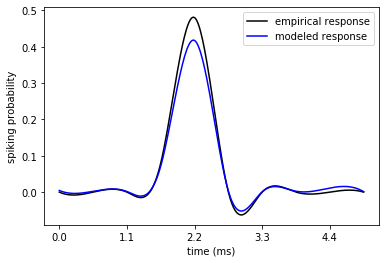

In [43]:
plt.plot(x_new, y0_new, 'k', label='empirical response')
plt.plot(x_new, z0_new, 'b', label='modeled response')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('spiking probability')
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 5.5, step=1.1))  # Set label locations.
#plt.grid()
plt.show()

In [68]:
y1 = resp_test[30].flatten()[2860:2870]
z1 = probs[30][2860:2870]

In [69]:
print(pearsonr(y1,z1))

(0.7148291295936178, 0.020160748261438308)


In [70]:
a_BSpline_y1 = interpolate.make_interp_spline(x, y1)
a_BSpline_z1 = interpolate.make_interp_spline(x, z1)
y1_new = a_BSpline_y1(x_new)
z1_new = a_BSpline_z1(x_new)

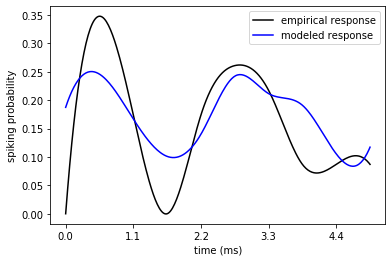

In [71]:
plt.plot(x_new, y1_new, 'k', label='empirical response')
plt.plot(x_new, z1_new, 'b', label='modeled response')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('spiking probability')
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 5.5, step=1.1))  # Set label locations.
#plt.grid()
plt.show()

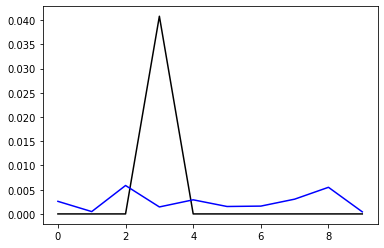

In [48]:
plt.plot(resp_test[2].flatten()[2860:2870], 'k', label='empirical response', )
plt.plot(probs[2][2860:2870], 'b', label='modeled response')
#plt.legend()
#plt.xlabel('time bins')
#plt.ylabel('spiking probability')
#plt.grid()
plt.show()

### Test first 20 units

In [9]:
corrs_full = []
corrs_full_sig = []
corrs_lin = []
corrs_lin_sig = []
units = []
for unit in clusters:
    # pred corr
    with open(os.path.join(MNE_test_dset_pred, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict = pickle.load(f)
    stims_test = test_dict['stims_test']
    resps_test = test_dict['resps_test']
    
    with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals = pickle.load(f)
    pfinal = pfinals[unit]
    
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test, sdim=64)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test, sdim=64)
    
    # sig corr
    with open(os.path.join(MNE_test_dset_sig, '_unit-{}_MNE.pkl'.format(unit)), 'rb') as f:
        test_dict_sig = pickle.load(f)
    stims_test_sig = test_dict_sig['stims_test']
    resps_test_sig = test_dict_sig['resps_test']
    
    with open(os.path.join(exp_path1, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:                          
        pfinals_sig = pickle.load(f)
    pfinal_sig = pfinals_sig[unit]
    
    probs_sig, corr_sig = evaluate_prediction(pfinal_sig, stims_test_sig, resps_test_sig, sdim=320)
    probs_lin_sig, corr_lin_sig = evaluate_pred_lin(pfinal_sig, stims_test_sig, resps_test_sig, sdim=320)
    
    # form lists of correlations
    corrs_full.append(corr[0])
    corrs_lin.append(corr_lin[0])
    corrs_full_sig.append(corr_sig[0])
    corrs_lin_sig.append(corr_lin_sig[0])
    units.append(unit)

In [10]:
ind = [i for i,v in enumerate(corrs_full) if v <= 0]
ind

[]

In [22]:
corrs_full1 = corrs_full
for index in sorted(ind, reverse=True):
    del corrs_full1[index]

In [23]:
corrs_full_sig1 = corrs_full_sig
for index in sorted(ind, reverse=True):
    del corrs_full_sig1[index]

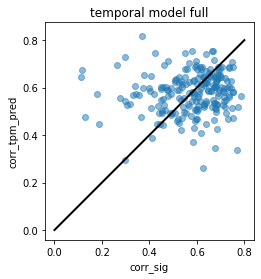

In [11]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_sig, corrs_full, alpha=0.5)
plt.plot([0, 0.8], [0, 0.8], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model full')
plt.xlabel('corr_sig')
plt.ylabel('corr_tpm_pred')
plt.show()

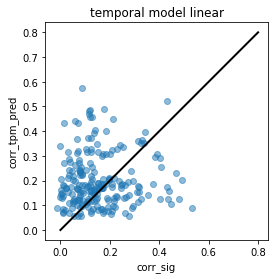

In [12]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_sig, corrs_lin, alpha=0.5)
plt.plot([0, 0.8], [0, 0.8], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model linear')
plt.xlabel('corr_sig')
plt.ylabel('corr_tpm_pred')
plt.show()

In [15]:
diag1 = np.array([0,0])
diag2 = np.array([0.8,0.8])
perp_dist = []
for i in range(len(corrs_full1)):
    p = np.array([corrs_full_sig1[i],corrs_full1[i]])
    d = np.cross(diag2 - diag1, p - diag1) / np.linalg.norm(diag2 - diag1)
    if corrs_full_sig1[i] > corrs_full1[i]:
        perp_dist.append(-1*d)
    else:
        perp_dist.append(d)

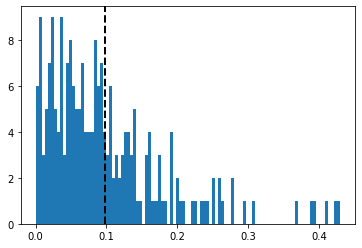

In [16]:
from scipy.stats import norm
import statistics

perp_dist = np.asarray(perp_dist)
plt.hist(perp_dist, 100)
  
# plotting mean line
plt.axvline(perp_dist.mean(), color='k', linestyle='dashed', linewidth=2)
  
# showing the plot
plt.show()

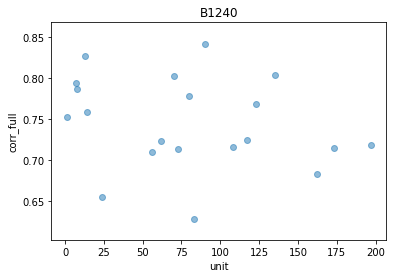

In [17]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_full, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_full')
plt.show()

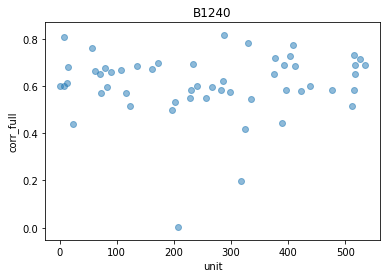

In [15]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_full, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_full')
plt.show()

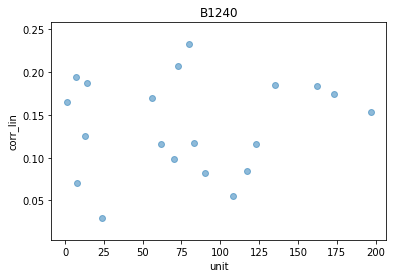

In [18]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_lin, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_lin')
plt.show()

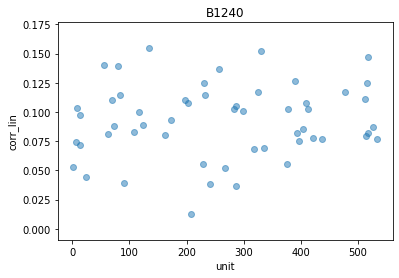

In [16]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_lin, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_lin')
plt.show()

In [9]:
for unit in units_to_process:
    with open(os.path.join(test_data_path, '{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
        test_dict = pickle.load(f)

    stims_test = test_dict['stims_test']
    resps_test = test_dict['resps_test']

    with open(os.path.join(exp_path, 'all_mua_MNEs_leave_first_stim.pkl'), 'rb') as f:                             #change
        pfinals = pickle.load(f)

    pfinal = np.mean(pfinals[unit], axis = 0)
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test)

    prob_dict = {'probs':probs, 'probs_lin': probs_lin, 'corr': corr, 'corr_lin': corr_lin}
    
#    print(corr[0])
    print(corr_lin[0])
#
#    with open(os.path.join(output_path, 'spike_prob_{}.pkl'.format(unit)), 'wb') as f:
#        pickle.dump(prob_dict, f)

0.30059669808507755
0.34442423207352374
0.12489318569219118
0.257688643994984
0.19969372626022872
0.15035933421275122
0.19122007665414853
0.19510316663148372
0.14783440335160733
0.1641191563604661
0.19855549569136666
-0.01836060512280107
0.14753009360048858
0.1302675130677518
0.0489261920218622
0.12675123358142334
0.09555067127551342
0.031964404742560036


In [44]:
unit = 2
print(unit)
unit_pred = []

with open(os.path.join(test_data_path, '{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
    test_dict = pickle.load(f)

stims_test = test_dict['stims_test']
resps_test = test_dict['resps_test']

with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
    pfinals = pickle.load(f)

pfinal_ = np.mean(pfinals[unit], axis = 0)
probs, corr = evaluate_prediction(pfinal, stims_test, resps_test)
probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test)

prob_dict = {'probs':probs, 'probs_lin': probs_lin, 'corr': corr, 'corr_lin': corr_lin}

with open(os.path.join(output_path, 'spike_prob_{}.pkl'.format(unit)), 'wb') as f:
    pickle.dump(prob_dict, f)

2


In [184]:
unit = 2
print(unit)
unit_pred = []

with open(os.path.join(resp_folder, 'G124-1 -1/good/{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
    test_dict = pickle.load(f)


stim_segs = np.asarray([x.flatten() for x in stim_segs_list])

### normalize stim_segs
norm_stim_segs = (stim_segs - np.min(stim_segs)) / (np.max(stim_segs) - np.min(stim_segs))
norm_stim_segs_1 = stim_segs
norm_stim_segs_1 /= np.max(np.abs(norm_stim_segs_1),axis=0)

resp_segs = segs_dict['resp']

with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
    pfinals = pickle.load(f)

for jack, pfinal in enumerate(pfinals[unit]):
    probs, probs_lin, spikes = predict_spiking_probability_response(pfinal, norm_stim_segs_1)
    jack_dict = {'jack':jack, 'probs':probs, 'probs_lin':probs_lin, 'spikes':spikes}
    unit_pred.append(jack_dict)

#output_file = os.path.join(output_path, 'spike_probs_resp_leave_first_stim_unit_{}.pkl'.format(unit))    #change
#with open(output_file, 'wb') as f:
#    pickle.dump(unit_pred, f)    

2


In [171]:
np.min(stim_segs), np.max(stim_segs)

(-60.299668594499764, 54.87281572344237)

In [185]:
np.min(norm_stim_segs_1), np.max(norm_stim_segs_1)

(-1.0, 1.0)

In [187]:
np.min(full_segs), np.max(full_segs), np.mean(full_segs)

(0.0016390483694475478, 0.8520878222044108, 0.19046477869612202)

In [192]:
full_segs = unit_pred[0]['probs']
lin_segs = unit_pred[0]['probs_lin']

full_segs_1 = full_segs - 0.1

for i in full_segs_1:
    if i < 0:
        i = 0

norm_resp_segs = (resp_segs - np.min(resp_segs))/(np.max(resp_segs) - np.min(resp_segs))
#norm_full_segs = (full_segs - np.min(full_segs))/(np.max(full_segs) - np.min(full_segs))
#norm_lin_segs = (lin_segs - np.min(lin_segs))/(np.max(lin_segs) - np.min(lin_segs))


In [153]:
full = gaussian_filter1d(full_segs, 15)
#orig = gaussian_filter1d(norm_resp_segs[20:], 15)
orig = gaussian_filter1d(resp_segs[20:], 15)
lin = gaussian_filter1d(lin_segs, 15)

In [154]:
from scipy.stats.stats import pearsonr  

print(pearsonr(orig, full))
print(np.corrcoef(orig, full))

(0.42936575948509914, 1.882616663682709e-136)
[[1.         0.42936576]
 [0.42936576 1.        ]]


In [183]:
print(pearsonr(norm_resp_segs[20:], full_segs))
print(np.corrcoef(norm_resp_segs[20:], full_segs))

(-0.026367106015829547, 0.1463683592370846)
[[ 1.         -0.02636711]
 [-0.02636711  1.        ]]


In [180]:
print(pearsonr(orig, lin))
print(np.corrcoef(orig, lin))

(0.028056858810279136, 0.12220168424019877)
[[1.         0.02805686]
 [0.02805686 1.        ]]


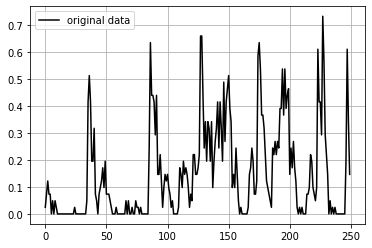

In [198]:
plt.plot(norm_resp_segs[20:][2750:3000], 'k', label='original data')
#plt.plot(full_segs_1[2700:2950], 'b', label='full data')
plt.legend()
plt.grid()
plt.show()

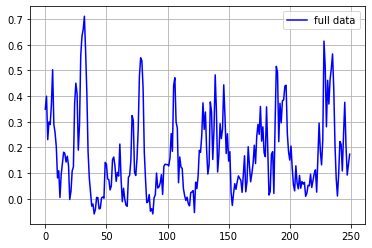

In [196]:
plt.plot(full_segs_1[2700:2950], 'b', label='full data')
plt.legend()
plt.grid()
plt.show()

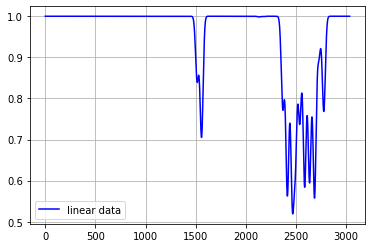

In [133]:
plt.plot(lin, 'b', label='linear data')
plt.legend()
plt.grid()
plt.show()

In [18]:
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)
array([ 1.42704095,  2.06782203,  3.        ,  3.93217797,  4.57295905])
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 4)
array([ 2.91948343,  2.95023502,  3.        ,  3.04976498,  3.08051657])
import matplotlib.pyplot as plt
np.random.seed(280490)
x = np.random.randn(101).cumsum()
y3 = gaussian_filter1d(x, 3)
y6 = gaussian_filter1d(x, 6)
plt.plot(x, 'k', label='original data')
plt.plot(y3, '--', label='filtered, sigma=3')
plt.plot(y6, ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()

1.0

In [24]:
for unit in units_to_process:
    print(unit)
    unit_pred = []
    with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
        pfinals = pickle.load(f)
        
    for jack, pfinal in enumerate(pfinals[unit]):
        probs, probs_lin, spikes = predict_spiking_probability_response(pfinal, stim_segs)
        jack_dict = {'jack':jack, 'probs':probs, 'probs_lin':probs_lin, 'spikes':spikes}
        unit_pred.append(jack_dict)
    
    output_file = os.path.join(output_path, 'spike_probs_resp_leave_first_stim_unit_{}.pkl'.format(unit))    #change
    with open(output_file, 'wb') as f:
        pickle.dump(unit_pred, f)    

In [26]:
np.shape(stim_segs)

(3036, 320)

In [ ]:

for unit in units_to_process:
    print(unit)
    with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
        pfinals = pickle.load(f)
    
    
    
    for jack, pfinal in enumerate(pfinals[unit]):
        

In [3]:
with open(os.path.join(exp_path, 'all_good_MNEs_leavefirst.pkl'), 'rb') as f:
    pfinals = pickle.load(f)

In [6]:
# mention which cell you want to do predictions for
unit = 2

sdim=320
intercept_avg = 0
a_avg = 0
j_avg = 0
n_jackknives = len(pfinals[unit])
for jack, pfinal in enumerate(pfinals[unit]):
    # extract a matrix 
    
    intercept = pfinal[0]
    intercept_avg += intercept
    a = pfinal[1:sdim+1]
    a = np.reshape(a,(16,20))
    a_avg += a
    # extract J matrix
    j = pfinal[-1*sdim**2:]
    j = np.reshape(j,(sdim,sdim))
    j_avg += j

intercept_avg /= n_jackknives
a_avg /= n_jackknives
j_avg /= n_jackknives

In [10]:
mne_stims_resps = glob.glob(os.path.join(MNE_prepro_path, '{}/*.pkl'.format(unit)))

stims = []
resps = []
for fpath in mne_stims_resps:
    
    with open(fpath, 'rb') as f:
        mne_stim_data = pickle.load(f)
        
    # extract stim features and respons
    segs = mne_stim_data['segs']
    resp = mne_stim_data['resp']
    
    # Each segment is nfreq x nbins.  Flatten
    fl_segs = [np.ravel(x[1]) for x in segs]
    
    # ignore first however many responses to correspond to each segment
    nsegs = len(segs)
    nresp = len(resp)
    diff = nresp - nsegs
    fl_resp = resp[diff:]
    assert(len(fl_resp) == len(fl_segs))
    
    MNE_stim = np.vstack(fl_segs)
    MNE_stim /= np.amax(MNE_stim)
    MNE_resp = np.copy(fl_resp)[:, np.newaxis]
    stims.append(MNE_stim)
    resps.append(MNE_resp)
    
stims = np.vstack(stims)
resps = np.vstack(resps)

In [12]:
# obtain test set (left out chunk while training)
# we will be predicting on this set
stims_leave = stims[:3088,:]
resps_leave = resps[:3088,:]

In [70]:
from scipy.io import savemat
savemat_dict = {'intercept': intercept_avg, 'h': a_avg_flatten, 'J': j_avg, 
                'stims_leave': stims_leave, 'resps_leave': resps_leave}

In [71]:
savemat(os.path.join(exp_path, 'savemat_dict_unit2.mat'), savemat_dict)

In [66]:
a_avg_flatten = np.reshape(a_avg, (320,1))

In [37]:
#f1 = 1+exp(a+stim_p*h'+sum(stim_p.*(stim_p*J),2));
a_times_s = np.matmul(stims_leave, np.reshape(a_avg, (320,1)))
s_J_s = np.matmul(stims_leave, np.transpose(np.matmul(stims_leave, j_avg))).sum(axis=1)
s_J_s = np.reshape(s_J_s, (3088,1))
#f1 = 1 + np.exp(intercept_avg + (stims_leave*h)+sum(stim_p.*(stim_p*J),2));

In [49]:
as_sJs = np.add(a_times_s, s_J_s)
bracket = intercept_avg + as_sJs

In [53]:
bracket

array([[4518.47065655],
       [4858.30183117],
       [4635.86401708],
       ...,
       [5378.97327554],
       [5057.05062882],
       [5490.84074309]])

In [39]:
denom = 1 + np.exp(intercept_avg + np.add(a_times_s, s_J_s))
p_spike_s = np.reciprocal(denom)

<ipython-input-39-34c5d10dcfe3>:1: RuntimeWarning: overflow encountered in exp
  denom = 1 + np.exp(intercept_avg + np.add(a_times_s, s_J_s))


In [55]:
p_spike_s[p_spike_s==1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
resps_leave

array([[0.25],
       [0.25],
       [0.2 ],
       ...,
       [0.25],
       [0.05],
       [0.15]])

In [58]:
j_avg

array([[-0.00323502,  0.00110018,  0.00521413, ...,  0.00370731,
         0.00431541,  0.00102155],
       [ 0.00110018, -0.00514909,  0.00309016, ...,  0.00180266,
         0.00098043,  0.00016933],
       [ 0.00521413,  0.00309016, -0.00411752, ...,  0.00057524,
         0.00112196, -0.00173775],
       ...,
       [ 0.00370731,  0.00180266,  0.00057524, ..., -0.00708458,
         0.00298167,  0.00277341],
       [ 0.00431541,  0.00098043,  0.00112196, ...,  0.00298167,
        -0.00495064,  0.00016745],
       [ 0.00102155,  0.00016933, -0.00173775, ...,  0.00277341,
         0.00016745, -0.00694784]])